# 3. Clusterização

##### Libraries

In [15]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
import matplotlib.pyplot as plt

from copy import deepcopy
from warnings import simplefilter 
#warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

simplefilter(action='ignore', category=ConvergenceWarning)
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
pd.set_option('display.max_columns', 999)
pd.options.mode.chained_assignment = None

In [16]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
plt.rcdefaults()
import matplotlib.font_manager as font_manager

##### Funções

In [67]:
def ideal_n_clusters(df, nclust=(3,15)):
    model = KMeans(init='k-means++', random_state=13) 
    visualizer = KElbowVisualizer(model, k=nclust, metric='distortion') 
    visualizer.fit(df)         
    visualizer.show() 
    
def distancia_clusters(df, model):
    visualizer = InterclusterDistance(model)
    visualizer.fit(df)        
    visualizer.show() 
    
def silhueta_clusters(df, model): 
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(df)
    visualizer.show()  
    
def fit_model(df, model, save=False, outname='model'):
    model.fit(df) 
    tmp = pd.concat([df, pd.DataFrame(model.labels_, columns=['cluster'])])
    print(tmp.cluster.value_counts())
    if save: 
        joblib.dump(model, f'./models/{outname}.joblib')
        tmp.to_csv(f'./data/{outname}.csv', index=False)
    return model, tmp

def amostra_clusters(model, df_in, df_base, n_idx=3, save=False, outname='sample'):
    df_ = pd.DataFrame() 
    nclust = model.get_params(['n_clusters'])['n_clusters']
    index = []
    label = []
    for i in range(nclust):
        for j in range(n_idx):
            label.append(i)
    for i in range(nclust):
        d = model.transform(df_in)[:, i]
        ind = np.argsort(d)[::][:n_idx]
        df_ = pd.concat([df_, df_base.iloc[ind]], ignore_index=True) 
        for j in ind:
            index.append(j)
    
    df_['index'] = index
    df_['cluster'] = label
    if save: df_.to_csv(f'{outname}.csv', index=False)
    return df_, index

def plot_clusters(df, model):
    pca = PCA(2)
    model_ = deepcopy(model)
    df_ = pca.fit_transform(df)
    model_.fit(df_) 
    df_ = pd.DataFrame(df_, columns=['pca0', 'pca1'])
    df_['cluster'] = model_.labels_
    sns.scatterplot(x='pca0', y='pca1', hue='cluster', data=df_, s=20, alpha=0.6, palette='tab10')
    plt.scatter(model_.cluster_centers_[:,0], model_.cluster_centers_[:,1], marker='x', s=70, c='k') #c=range(len(model_.cluster_centers_[:,0])), cmap='tab10')

In [32]:
import matplotlib.patheffects as path_effects


def add_median_labels(ax, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

##### Dados originais

In [114]:
df_clean = pd.read_csv('./data/xxxxxxxxxxx.csv')
df_norm = pd.read_csv('./data/xxxxxxxxxxxxx.csv')

##### 1. RFE + RF

In [36]:
X = df_norm.drop('xxxxx', axis=1)
y = df_norm.xxxxx.values #target

In [37]:
rfc = RandomForestClassifier(random_state=101, class_weight='balanced')
kfold = StratifiedKFold(n_splits=5, shuffle=True) 
cv = kfold.split(X, y)
rfecv = RFECV(estimator=rfc, step=5, min_features_to_select=15, cv=cv)

In [38]:
rfecv.fit(X, y)

RFECV(cv=<generator object _BaseKFold.split at 0x7f2cee58c4a0>,
      estimator=RandomForestClassifier(class_weight='balanced',
                                       random_state=101),
      min_features_to_select=15, step=5)

In [44]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 15


In [1]:
X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)

dset = pd.DataFrame()

dset['attr'] = X2.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=True)

fig = plt.figure(figsize=(16, 12))
plt.barh(y=dset['attr'], width=dset['importance'], color='red')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

NameError: name 'X' is not defined

In [ ]:
print([f'{x}: {y*100:.2f}%' for x,y in zip(dset.attr, dset.importance.sort_values(ascending=True))])

['DIAS_EM_ATRASO-90-120: 0.00%', 'SALDO_DEVEDOR: 0.00%', 'SCORE_ATUAL: 0.01%', 'DIAS_EM_ATRASO-180-360: 0.01%', 'TEMPO_MIN_CONTRATO_FIN: 0.42%', 'PERC_SALDO_DEVEDOR: 1.44%', 'MEDIA_DIAS_EM_ATRASO: 1.64%', 'N_PARC_EM_ATRASO: 5.61%', 'PERC_CONTRATO_ATRASADO: 6.42%', 'MAX_DIAS_EM_ATRASO: 7.36%', 'VALOR_MEDIO_PARCELAS_ATRASO: 10.28%', 'PERC_CONTRATO_INADIMPLENTE: 15.60%', 'VALOR_INADIMPLENTE: 15.92%', 'VALOR_MEDIO_PARCELAS_INADIMPLENTES: 16.99%', 'N_PARC_INADIMPLENTE: 18.31%']


In [ ]:
cols_rfe = dset.attr
cols_rfe

9                  DIAS_EM_ATRASO-90-120
13                         SALDO_DEVEDOR
10                           SCORE_ATUAL
8                 DIAS_EM_ATRASO-180-360
0                 TEMPO_MIN_CONTRATO_FIN
14                    PERC_SALDO_DEVEDOR
4                   MEDIA_DIAS_EM_ATRASO
6                       N_PARC_EM_ATRASO
11                PERC_CONTRATO_ATRASADO
3                     MAX_DIAS_EM_ATRASO
1            VALOR_MEDIO_PARCELAS_ATRASO
12            PERC_CONTRATO_INADIMPLENTE
5                     VALOR_INADIMPLENTE
2     VALOR_MEDIO_PARCELAS_INADIMPLENTES
7                    N_PARC_INADIMPLENTE
Name: attr, dtype: object

In [2]:
df_rfe = df_norm[cols_rfe.tolist()+[
'lista de colunas do rfe']]
df_rfe.head(3)

NameError: name 'df_norm' is not defined

In [61]:
df_rfe.to_csv('./data/data_rfe_norm.csv', index=False)

##### 2. Clusterização usando Kmeans

In [62]:
df_rfe = pd.read_csv('./data/data_rfe_norm.csv')

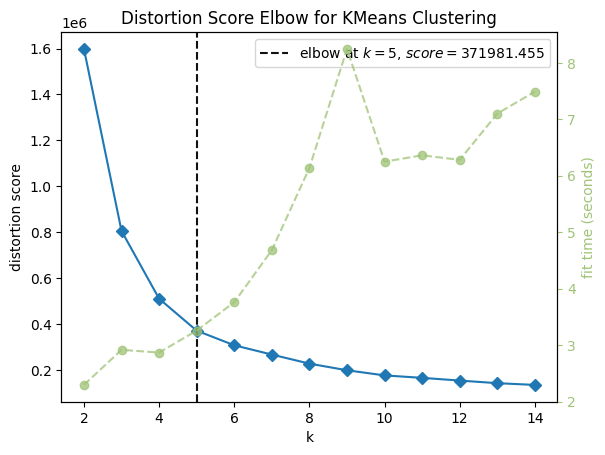

In [63]:
ideal_n_clusters(df_rfe, nclust=(2,15))

In [64]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=13)

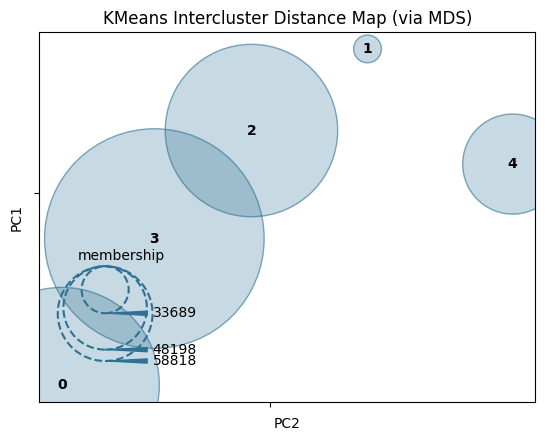

In [65]:
distancia_clusters(df_rfe, kmeans)

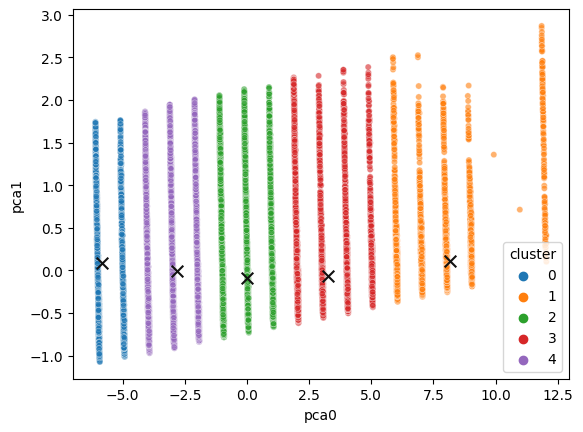

In [68]:
plot_clusters(df_rfe, kmeans)

In [70]:
kmeans_fit, _ = fit_model(df_rfe, kmeans, save=True, outname='kmeans_rfe')

4.0    75437
1.0    58818
0.0    48198
2.0    33689
3.0    32044
Name: cluster, dtype: int64


In [3]:
sample, index = amostra_clusters(kmeans_fit, df_rfe, df_clean, n_idx=50, save=True, outname='./data/sample_rfe')
sample

NameError: name 'amostra_clusters' is not defined

In [4]:
plot_clusters(df_norm.iloc[index], kmeans)

NameError: name 'plot_clusters' is not defined

In [73]:
# Loading kmeans model 

kmeans_rfe = joblib.load('./models/kmeans_rfe.joblib')

In [112]:
# Loading dataframe generated in RFE step

df_rfe = pd.read_csv('./data/data_rfe_norm.csv')

In [5]:
df_rfe.columns.tolist()

NameError: name 'df_rfe' is not defined

In [6]:
# Getting cluster prediction for all 

data_rfe = df_clean.copy()
data_rfe['cluster'] = kmeans_rfe.predict(df_rfe)
data_rfe.head(3)

NameError: name 'df_clean' is not defined

In [7]:
# Distribution into clusters

data_rfe.cluster.value_counts()

NameError: name 'data_rfe' is not defined

In [77]:
# Saving csv for analysis

data_rfe.to_csv('./data/dados_cluster_rfe.csv', index=False)

In [ ]:
### Parei aqui

##### 3. EDA dos clusters

In [473]:
data_rfe = pd.read_csv('./data/dados_cluster_rfe.csv')

In [8]:
def format_numbers(x, d=2):
    x = str(round(x,d)).replace('.', ',')
    b = x.split(',')[0]
    a = x.split(',')[1]
    if len(b) <= 3:
        return x
    elif 3 < len(b) <= 6:
        return b[-10:-3]+'.'+b[-3:]+','+a
    elif 6 < len(b) <= 9:
        return b[-9:-6]+'.'+b[-6:-3]+'.'+b[-3:]+','+a
    else:
        return b[-12:-9]+'.'+b[-9:-6]+'.'+b[-6:-3]+'.'+b[-3:]+','+a
    
# Para variáveis numéricas!

# colunas = [xxxxxxxxxxxxxx]
# colunas = ['xxxxxxxxxxxx
# ]
colunas = [xxxxxxxxxxxxx]
cluster_valores = []
cluster_nomes = []
dec = 2
for col in colunas:
    print('###', col, '###')
    div = 365 if 'TEMPO' in col else 1
    mul = 100 if 'PERC' in col else 1
    sig = '%' if 'PERC' in col else ''
    rsig = 'R$' if 'VALOR' in col or 'SALDO' in col and 'PERC' not in col else ''
    
    for i in range(5): 
        x_media_sim = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'SIM')).mean()*mul/div
        x_mediana_sim = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'SIM')).median()*mul/div
        
        cluster_valores.append(' | ' + f'{rsig}{format_numbers(x_media_sim, dec)}{sig}' + '(' +  f'{rsig}{format_numbers(x_mediana_sim, dec)}{sig}' + ')')
        cluster_nomes.append(f'| '+ col + ' '+'**Inad**')
        
        x_media_nao = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'NAO')).mean()*mul/div
        x_mediana_nao = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'NAO')).median()*mul/div

        cluster_valores.append(' | ' + f'{rsig}{format_numbers(x_media_nao, dec)}{sig}' + '(' +  f'{rsig}{format_numbers(x_mediana_nao, dec)}{sig}' + ')')
        cluster_nomes.append(f'| '+ col + ' '+'**Adim**')

        
        x_media_g = data_rfe[col].where((data_rfe.cluster == i)).mean()*mul/div
        x_mediana_g = data_rfe[col].where((data_rfe.cluster == i)).median()*mul/div

        cluster_valores.append(' | ' + f'{rsig}{format_numbers(x_media_g, dec)}{sig}' + '(' +  f'{rsig}{format_numbers(x_mediana_g, dec)}{sig}' + ')')
        cluster_nomes.append(f'| '+ col + ' '+'**Geral**')

NameError: name 'xxxxxxxxxxxxx' is not defined

In [9]:
d = {'valores': cluster_valores, 'variavel': cluster_nomes}
df = pd.DataFrame(data=d)

df = df.groupby('variavel')['valores'].apply(list).reset_index(name='valores')
df['valores'] = df['valores'].apply(lambda x:  ' '.join(str(item) for item in x))

df[['variavel','valores']] = df[['variavel','valores']].astype(str)
df['out'] = df['variavel'] + df['valores']

lista = df['out'].tolist()
retorno = [x + ' |' for x in lista]


NameError: name 'cluster_valores' is not defined

In [10]:
for i in retorno:
    print(i)

NameError: name 'retorno' is not defined

In [499]:
# def format_numbers(x, d=2):
#     x = str(round(x,d)).replace('.', ',')
#     b = x.split(',')[0]
#     a = x.split(',')[1]
#     if len(b) <= 3:
#          return x
#     elif 3 < len(b) <= 6:
#         return b[-10:-3]+'.'+b[-3:]+','+a
#     elif 6 < len(b) <= 9:
#         return b[-9:-6]+'.'+b[-6:-3]+'.'+b[-3:]+','+a
#     else:
#         return b[-12:-9]+'.'+b[-9:-6]+'.'+b[-6:-3]+'.'+b[-3:]+','+a

# cols_cliente = ['VALOR_MEDIO_PARCELAS_ATRASO','VALOR_MEDIO_PARCELA_FIN']
# for col in cols_cliente:
#     print('###', col, '###')
#     for i in range(5):
#         print('Cluster ', i)
#         x_ = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'SIM')).mean()
#         x = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'NAO')).mean()
#         x__ = data_rfe[col].where((data_rfe.cluster == i)).mean()
#         print(f'média grupo inadimplente: {format_numbers(x_)} | média grupo adimplente: {format_numbers(x)} | média grupo geral: {format_numbers(x__)}')
#         x_ = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'SIM')).median()
#         x = data_rfe[col].where((data_rfe.cluster == i) & (data_rfe.INADIMPLENTE == 'NAO')).median()
#         x__ = data_rfe[col].where((data_rfe.cluster == i)).median()

#         print(f'mediana grupo inadimplente: {format_numbers(x_)} | mediana grupo adimplente: {format_numbers(x)}| mediana grupo geral: {format_numbers(x__)}')

#         print('---------------------------')
#         print('====================')

In [24]:
cols_cliente = [
       'AUMENTO_LIMITE', 'REDUCAO_LIMITE', 'SCORE_ATUAL', 'AUMENTO_SCORE', 'REDUCAO_SCORE',
       'TOTAL_CONTRATOS_FIN', 'SOMA_VALOR_CONTRATO_FIN', 'SOMA_VALOR_NOTA_FIN','SOMA_VALOR_CONTRATO_FIN','VALOR_MEDIO_CONTRATO_FIN', 'TEMPO_MEDIO_CONTRATO_FIN',
       'TEMPO_MIN_CONTRATO_FIN','TEMPO_MAX_CONTRATO_FIN','VALOR_MEDIO_ENTRADA_FIN','VALOR_MEDIO_PARCELA_FIN','VALOR_MEDIO_QTEPARC_FIN','VALOR_MAX_QTEPARC_FIN','VALOR_MEDIO_JUROS_FIN',
       'MAX_DIAS_ANTECIPOU','MAX_DIAS_ANTECIPOU',
'MAX_DIAS_EM_ATRASO',
'MEDIA_DIAS_EM_ATRASO',
'PERC_PAG_EM_DIA',
'PERC_CONTRATO_INADIMPLENTE', 
'PERC_SALDO_DEVEDOR',
'N_PARC_EM_ATRASO',
'VALOR_MEDIO_PARCELAS_ATRASO', 
'SALDO_DEVEDOR', 
'N_PARC_INADIMPLENTE',
'VALOR_INADIMPLENTE'
       ]
for col in cols_cliente:
    print('###', col, '###')
    for i in range(5):
        print('Cluster ', i)    
        
        print(f'| '+ col + ' | ' + f'{data_rfe[col].where(data_rfe.cluster == i).mean():.1f}' + '(' +  f'{data_rfe[col].where(data_rfe.cluster == i).median():.1f}' + ')' + ' |')
        print('---------------------------')
    print('====================')


### AUMENTO_LIMITE ###
Cluster  0
| AUMENTO_LIMITE | 1.3(1.0) |
---------------------------
Cluster  1
| AUMENTO_LIMITE | 0.4(0.0) |
---------------------------
Cluster  2
| AUMENTO_LIMITE | 1.7(2.0) |
---------------------------
Cluster  3
| AUMENTO_LIMITE | 2.0(2.0) |
---------------------------
Cluster  4
| AUMENTO_LIMITE | 0.8(1.0) |
---------------------------
### REDUCAO_LIMITE ###
Cluster  0
| REDUCAO_LIMITE | 0.6(0.0) |
---------------------------
Cluster  1
| REDUCAO_LIMITE | 0.6(0.0) |
---------------------------
Cluster  2
| REDUCAO_LIMITE | 0.1(0.0) |
---------------------------
Cluster  3
| REDUCAO_LIMITE | 0.2(0.0) |
---------------------------
Cluster  4
| REDUCAO_LIMITE | 0.6(0.0) |
---------------------------
### SCORE_ATUAL ###
Cluster  0
| SCORE_ATUAL | 38.5(33.2) |
---------------------------
Cluster  1
| SCORE_ATUAL | 19.7(14.8) |
---------------------------
Cluster  2
| SCORE_ATUAL | 75.2(82.5) |
---------------------------
Cluster  3
| SCORE_ATUAL | 57.7(62.6) |


> **CLUSTER 0**

In [12]:
# The most of data are concentrated in AMAZONAS, RONDONIA, RORAIMA and ACRE

data_rfe['ESTADO'].replace([x for x in data_rfe.ESTADO.unique() if x not in ['AMAZONAS', 'ACRE', 'RONDONIA', 'RORAIMA']], 'OUTROS', inplace=True)

In [14]:
data_rfe.shape

(248186, 106)

In [11]:
fig, axs = plt.subplots(2,3, figsize=[28,12])
data_rfe.SEXO.value_counts().plot.pie(ylabel=' ', ax=axs[0,0], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO.value_counts().plot.pie(ylabel=' ', ax=axs[0,1], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO_CIVIL.value_counts().plot.pie(ylabel=' ', ax=axs[0,2], fontsize=14, autopct='%.0f%%')
data_rfe['CREDITO'].value_counts().plot.pie(ylabel=' ', ax=axs[1,0], fontsize=14, autopct='%.0f%%')
data_rfe.RECEBIDOS.value_counts().plot.pie(ylabel=' ', ax=axs[1,1], fontsize=14, autopct='%.0f%%')
data_rfe.INADIMPLENTE.value_counts().plot.pie(ylabel=' ', ax=axs[1,2], fontsize=14, autopct='%.0f%%')

NameError: name 'plt' is not defined

In [12]:
fig, axs = plt.subplots(2,3, figsize=[28,12])
data_rfe.SEXO.where(data_rfe.cluster == 0).value_counts().plot.pie(ylabel=' ', ax=axs[0,0], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO.where(data_rfe.cluster == 0).value_counts().plot.pie(ylabel=' ', ax=axs[0,1], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO_CIVIL.where(data_rfe.cluster == 0).value_counts().plot.pie(ylabel=' ', ax=axs[0,2], fontsize=14, autopct='%.0f%%')
data_rfe['CREDITO'].where(data_rfe.cluster == 0).value_counts().plot.pie(ylabel=' ', ax=axs[1,0], fontsize=14, autopct='%.0f%%')
data_rfe.RECEBIDOS.where(data_rfe.cluster == 0).value_counts().plot.pie(ylabel=' ', ax=axs[1,1], fontsize=14, autopct='%.0f%%')
data_rfe.INADIMPLENTE.where(data_rfe.cluster == 0).value_counts().plot.pie(ylabel=' ', ax=axs[1,2], fontsize=14, autopct='%.0f%%')

NameError: name 'plt' is not defined

> **CLUSTER 1**

In [13]:
fig, axs = plt.subplots(2,3, figsize=[28,12])
data_rfe.SEXO.where(data_rfe.cluster == 1).value_counts().plot.pie(ylabel=' ', ax=axs[0,0], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO.where(data_rfe.cluster == 1).value_counts().plot.pie(ylabel=' ', ax=axs[0,1], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO_CIVIL.where(data_rfe.cluster == 1).value_counts().plot.pie(ylabel=' ', ax=axs[0,2], fontsize=14, autopct='%.0f%%')
data_rfe['CREDITO'].where(data_rfe.cluster == 1).value_counts().plot.pie(ylabel=' ', ax=axs[1,0], fontsize=14, autopct='%.0f%%')
data_rfe.RECEBIDOS.where(data_rfe.cluster == 1).value_counts().plot.pie(ylabel=' ', ax=axs[1,1], fontsize=14, autopct='%.0f%%')
data_rfe.INADIMPLENTE.where(data_rfe.cluster == 1).value_counts().plot.pie(ylabel=' ', ax=axs[1,2], fontsize=14, autopct='%.0f%%')

NameError: name 'plt' is not defined

> **CLUSTER 2**

In [14]:
fig, axs = plt.subplots(2,3, figsize=[28,12])
data_rfe.SEXO.where(data_rfe.cluster == 2).value_counts().plot.pie(ylabel=' ', ax=axs[0,0], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO.where(data_rfe.cluster == 2).value_counts().plot.pie(ylabel=' ', ax=axs[0,1], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO_CIVIL.where(data_rfe.cluster == 2).value_counts().plot.pie(ylabel=' ', ax=axs[0,2], fontsize=14, autopct='%.0f%%')
data_rfe['CREDITO'].where(data_rfe.cluster == 2).value_counts().plot.pie(ylabel=' ', ax=axs[1,0], fontsize=14, autopct='%.0f%%')
data_rfe.RECEBIDOS.where(data_rfe.cluster == 2).value_counts().plot.pie(ylabel=' ', ax=axs[1,1], fontsize=14, autopct='%.0f%%')
data_rfe.INADIMPLENTE.where(data_rfe.cluster == 2).value_counts().plot.pie(ylabel=' ', ax=axs[1,2], fontsize=14, autopct='%.0f%%')

NameError: name 'plt' is not defined

> **CLUSTER 3**

In [15]:
fig, axs = plt.subplots(2,3, figsize=[28,12])
data_rfe.SEXO.where(data_rfe.cluster == 3).value_counts().plot.pie(ylabel=' ', ax=axs[0,0], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO.where(data_rfe.cluster == 3).value_counts().plot.pie(ylabel=' ', ax=axs[0,1], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO_CIVIL.where(data_rfe.cluster == 3).value_counts().plot.pie(ylabel=' ', ax=axs[0,2], fontsize=14, autopct='%.0f%%')
data_rfe['CREDITO'].where(data_rfe.cluster == 3).value_counts().plot.pie(ylabel=' ', ax=axs[1,0], fontsize=14, autopct='%.0f%%')
data_rfe.RECEBIDOS.where(data_rfe.cluster == 3).value_counts().plot.pie(ylabel=' ', ax=axs[1,1], fontsize=14, autopct='%.0f%%')
data_rfe.INADIMPLENTE.where(data_rfe.cluster == 3).value_counts().plot.pie(ylabel=' ', ax=axs[1,2], fontsize=14, autopct='%.0f%%')

NameError: name 'plt' is not defined

In [16]:
fig, axs = plt.subplots(2,3, figsize=[28,12])
data_rfe.SEXO.where(data_rfe.cluster == 4).value_counts().plot.pie(ylabel=' ', ax=axs[0,0], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO.where(data_rfe.cluster == 4).value_counts().plot.pie(ylabel=' ', ax=axs[0,1], fontsize=14, autopct='%.0f%%')
data_rfe.ESTADO_CIVIL.where(data_rfe.cluster ==4).value_counts().plot.pie(ylabel=' ', ax=axs[0,2], fontsize=14, autopct='%.0f%%')
data_rfe['CREDITO'].where(data_rfe.cluster == 4).value_counts().plot.pie(ylabel=' ', ax=axs[1,0], fontsize=14, autopct='%.0f%%')
data_rfe.RECEBIDOS.where(data_rfe.cluster == 4).value_counts().plot.pie(ylabel=' ', ax=axs[1,1], fontsize=14, autopct='%.0f%%')
data_rfe.INADIMPLENTE.where(data_rfe.cluster == 4).value_counts().plot.pie(ylabel=' ', ax=axs[1,2], fontsize=14, autopct='%.0f%%')

NameError: name 'plt' is not defined

In [17]:
# Idade

for i in range(5):
    print('Cluster ', i)    
    print(f'média: {data_rfe.AGE.where(data_rfe.cluster == i).mean():.1f}')
    print(f'mediana: {data_rfe.AGE.where(data_rfe.cluster == i).median():.1f}')

Cluster  0


NameError: name 'data_rfe' is not defined

In [18]:
ax = sns.boxplot(x=data_rfe.cluster, y=data_rfe.AGE, showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
add_median_labels(ax)
plt.show()

NameError: name 'sns' is not defined

In [10]:
# Tempo de casa

for i in range(5):
    print('Cluster ', i)    
    print(f'média: {data_rfe.TEMPO_DE_CASA.where(data_rfe.cluster == i).mean()/365:.1f}')
    print(f'mediana: {data_rfe.TEMPO_DE_CASA.where(data_rfe.cluster == i).median()/365:.1f}')

Cluster  0
média: 10.2
mediana: 9.2
Cluster  1
média: 5.2
mediana: 3.4
Cluster  2
média: 16.1
mediana: 15.6
Cluster  3
média: 12.3
mediana: 11.1
Cluster  4
média: 7.9
mediana: 6.0


In [19]:
ax = sns.boxplot(x=data_rfe.cluster, y=data_rfe.DATABASE/365, showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
add_median_labels(ax)
plt.show()

NameError: name 'sns' is not defined

In [20]:
cols_cliente = [
       XXXXXXXXXX #infos do fornecedor
       ]
for col in cols_cliente:
    print('###', col, '###')
    for i in range(5):
        print('Cluster ', i)    
        print(f'média: {data_rfe[col].where(data_rfe.cluster == i).mean():.1f}')
        print(f'mediana: {data_rfe[col].where(data_rfe.cluster == i).median():.1f}')
        print('---------------------------')
    print('====================')

NameError: name 'XXXXXXXXXX' is not defined

In [21]:

cols_cliente = [xxxxxxxxxxxxx
]

for col in cols_cliente:
    print('###', col, '###')
    for i in range(5):
        df = data_rfe[data_rfe['naopaga'] == 'SIM']
        print('Cluster ', i)    
        print(f'média: {df[col].where(df.cluster == i).mean():.2f}')
        print(f'mediana: {df[col].where(df.cluster == i).median():.2f}')
        print('---------------------------')
    print('====================')

NameError: name 'xxxxxxxxxxxxx' is not defined

##### analises percentuais

In [22]:
for i in range(5):
    print('Cluster ', i)    
    print(f'média: {data_rfe.DINHEIRO_NAOPAGA.where(data_rfe.cluster == i).mean():.1f}')
    print(f'mediana: {data_rfe.DINHEIRO_NAOPAGA.where(data_rfe.cluster == i).median():.1f}')
    
ax = sns.boxplot(x=data_rfe.cluster, y=data_rfe.DINHEIRO_NAOPAGA, showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
add_median_labels(ax)
plt.show()

Cluster  0


NameError: name 'data_rfe' is not defined

In [23]:
for i in range(5):
    print('Cluster ', i)    
    print(f'média: {data_rfe.PERCDEVE.where(data_rfe.cluster == i).mean()*100:.1f}')
    print(f'mediana: {data_rfe.PERCDEVE.where(data_rfe.cluster == i).median()*100:.1f}')
    
ax = sns.boxplot(x=data_rfe.cluster, y=data_rfe.PERCDEVE, showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
add_median_labels(ax)
plt.show()

Cluster  0


NameError: name 'data_rfe' is not defined

In [24]:
for i in range(5):
    print('Cluster ', i)    
    print(f'média: {data_rfe.OERC_PENDENDTE.where(data_rfe.cluster == i).mean()*100:.1f}')
    print(f'mediana: {data_rfe.OERC_PENDENDTE.where(data_rfe.cluster == i).median()*100:.1f}')
    
ax = sns.boxplot(x=data_rfe.cluster, y=data_rfe.OERC_PENDENDTE, showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
add_median_labels(ax)
plt.show()

Cluster  0


NameError: name 'data_rfe' is not defined

In [25]:
for i in range(5):
    print('Cluster ', i)    
    print(f'média: {data_rfe.PERC_ADIMPLENTE.where(data_rfe.cluster == i).mean()*100:.1f}')
    print(f'mediana: {data_rfe.PERC_ADIMPLENTE.where(data_rfe.cluster == i).median()*100:.1f}')
    
ax = sns.boxplot(x=data_rfe.cluster, y=data_rfe.PERC_ADIMPLENTE, showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
add_median_labels(ax)
plt.show()

Cluster  0


NameError: name 'data_rfe' is not defined

In [26]:
for i in range(5):
    print('Cluster ', i)    
    print(f'média: {data_rfe.CONTRATO.where(data_rfe.cluster == i).mean()*100:.1f}')
    print(f'mediana: {data_rfe.CONTRATO.where(data_rfe.cluster == i).median()*100:.1f}')
    
ax = sns.boxplot(x=data_rfe.cluster, y=data_rfe.CONTRATO, showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})
add_median_labels(ax)
plt.show()

Cluster  0


NameError: name 'data_rfe' is not defined

In [132]:
!pip install ipyparams

  Preparing metadata (setup.py) ... done
  Created wheel for ipyparams: filename=ipyparams-0.2.1-py3-none-any.whl size=2764 sha256=3f5e2eaaa62c1f9d5f4e9b2a8cc7b675ca7dff2ae374361050f91b69ace22341
  Stored in directory: /home/tatianecorreia/.cache/pip/wheels/da/e5/08/62102ec78fa21e5cc63ac9d6cc85b30971817e91ce021a6613
Successfully built ipyparams


In [133]:
%matplotlib inline
import os 
import ipyparams

<IPython.core.display.Javascript object>